# Building a Weather Station with TensorFlow Lite for Microcontrollers
**Final Project for [Kodołamacz Data Science PRO](https://datasciencepro.kodolamacz.pl/?_gl=1*f9bzqb*_ga*NzExNzQ1MTc5LjE2NzQ5NzkxMTM.*_ga_L4TZ9764GC*MTY5NTc0MTM1NS44My4wLjE2OTU3NDEzNTUuNjAuMC4w) Bootcamp, Author: Michał Dąbrowski, PhD**

## Motivation

I have been inspired by [Smart weather station challenge](https://challenge.aiforgood.itu.int/match/matchitem/71). Here is a short description of the problem in that competition:

> Developing Countries is the area of the globe where land-based, in situ monitoring of weather and climate is at its scarcest, but at the same time has arguably the most potential to benefit society. Rainfall and temperature can have high spatial variability due to the strong feedback that can exist between the land and atmosphere. Temperature can change rapidly in space due to land-cover heterogeneity and changing altitude over complex mountainous terrain. This means that a weather station tens of kilometers away may measure conditions that have little relevance to your location, making it hard to make informed local decisions. Attempts can be made to supplement weather information with satellite data, but these infer rainfall and near surface temperature at spatially averaged scales exceeding 10km and are subject to considerable uncertainties despite advances in sensor technology; moreover some data such as near surface winds or solar flux are not available at all. Local weather information can have a huge impact on communities and applications enabled by granular weather data include agriculture, change in prices of commodities and early warning systems.

![WeatherMap](https://www.researchgate.net/profile/Gamal-El-Afandi/publication/263863861/figure/fig9/AS:668435407179790@1536378828611/the-location-of-the-worlds-key-weather-stations-shows-huge-areas-where-information-is-not.jpg)

The goal of this challenge was to develop a fully functioning low-power, reliable, accurate, easy to install and maintain cost effective [weather station based on a single device](./TinyML_Challenge_2022_CSEM_report.pdf) able to detect all weather parameters including __TPH__ (temperature, pressure and humidity), wind and rain with no moving parts based on ultra-low power machine learning at the edge, that can be deployed locally in a farm, for example, to provide local conditions and assist farmers in deciding when to plant crops. __Thus I decided to build my own microcontroller-based station to predict weather conditions in Warsaw using [TinyML framework](https://www.oreilly.com/library/view/tinyml/9781492052036/).__

### TinyML with TensorFlow Lite for Microcontrollers (TFLu) with Arduino Nano 33 BLE Sense
TinyML is a new technology that allows Machine Learning (ML) models to run on low-power microcontrollers that do not require a network infrastructure. Generally, these devices have limited memory and computational capabilities, but they can _sense_ the physical environment through sensors and act based on the decisions taken by ML algorithms. It is firmly believed TinyML has a great role to play not only to reach the Sustainable Development Goals, but also to facilitate scientific research in areas such as environmental monitoring, physics of complex systems and energy management. One of the most popular and easy to develop model with is the [**Arduino Nano 33 BLE Sense**](https://docs.arduino.cc/hardware/nano-33-ble-sense) board with support from [**Tensor Flow Lite for Microcontrollers**](https://www.tensorflow.org/lite/microcontrollers) (TFLu) framework allowing running deep learning models on devices with a few kilobytes of memory, which we use to realize the current project. Written in C/C++, the library requires neither an operating system nor dynamic memory allocation. The ___Arduino Nano 33 BLE Sens___ currently has __TPH sensors__ which enable the temperature, humidity and atmospheric preasure measurements on-device in real time. Similar [weather stations](https://github.com/FlorinAndrei/WeatherStation) were realized in the past using different microcontrollers platforms and datasets e.g., [here](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) or [there](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) thus being helpful as as a source of inspiration and code snippets.

<img src="https://courses.edx.org/assets/courseware/v1/c97238ff2db3e1872c67968473dc482f/asset-v1:HarvardX+TinyML3+1T2023+type@asset+block/pasted_image_0.png" width="600"/>

> __NOTE__: Excelent curated list of interesting resources on TinyML (articles, courses, books, and projects) is provided on [gitHub](https://github.com/gigwegbe/tinyml-papers-and-projects) profile.

## Project Dependencies

For details about the version of the Python packages installed when running the current notebook, see [requirements.txt](./requirements.txt).

### Python Libraries

In [48]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

sns.set()

### Constants

In [18]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 20
OUTPUT_DATASET_FILE = "outputs/dataset.csv"
TFL_MODEL_FILE = "outputs/forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "outputs/forecast_model.h"
TF_MODEL = "outputs/forecast"

## Importing weather data from _WorldWeatherOnline_

On the internet, there are various sources from which we can gather hourly weather data, but most of them are not free or have limited usage. I decided to use [___WorldWeatherOnline___](https://www.worldweatheronline.com/weather-api/) which has a free trial period for 30 days and provides simple [API](https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx) through HTTP requests to aquire the data (including historical data from July 1, 2008) for different locations worldwide. However, we can use an existing [Python wrapper](https://pypi.org/project/wwo-hist/) to export the data directly to pandas DataFrame or save them into CSV file. Other solutions will require web scrapping (using `selenium` webdriver), gathering the data from [another database](https://www.weatherapi.com/) or external file.

> __NOTE:__ The original wrapper file needs to be modified as it does not work for `pandas` versions later than 1.3.5 (argument `closed` is no longer supported and needs to be removed from arguments list). Please find properly modified `retrieve_this_location()` function [here](./wwo_hist-0.0.7/wwo_hist/__init__.py) (`__init__.py` file) and replace the original `__init__.py` file from the Python packages directory corresponding to `wwo-hist` package.

In [4]:
# !pip install wwo-hist
from wwo_hist import retrieve_hist_data  # WorldWeatherOnline

In [14]:
# acquire data from 01-JUL-2008 to 31-AUG-2023) with an hourly frequency from Warsaw

api_key = '2960e09342944d7589d182440232409'  # you need to register to obtain a personal API key (FREE 500 queries/day)
location_list = ['warsaw']
start_date = '01-JUL-2008'
end_date = '31-AUG-2023'
frequency=1  # weather conditions every 1 hour (costs 1 query for a whole month period per single location)

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for warsaw


Currently retrieving data for warsaw: from 2023-07-01 to 2023-07-31
Time elapsed (hh:mm:ss.ms) 0:00:01.913675
Currently retrieving data for warsaw: from 2023-07-01 to 2023-08-31
Time elapsed (hh:mm:ss.ms) 0:00:04.002406
Currently retrieving data for warsaw: from 2023-08-01 to 2023-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.515735


export warsaw completed!




In [7]:
# export to CSV file
df_weather[0].to_csv('weather_warsaw.csv', index=False)

The `weather` dataset includes several weather conditions for each requested data and time. For example, we can ind the pressure in milibars, cloud coverage in percentage, visibility in kilometers, and of course other physical quantities. The effectiveness of ML algorithms depends heavily on the data used for training (hence _ML model is only as good as the dataset_). Considering the weather prediciton context, we know from physics that temperature and humidity affect snow formation. Thus, we gather historical hourly temperature, humidity and snowfall data to build a __TinyML__ snow forecasting application based on data from the past three hours.

In [19]:
df_weather = pd.read_csv('weather_warsaw.csv')
df_weather.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-07-01 00:00:00,24,13,0.0,16.8,5,4,01:47 AM,08:04 PM,04:19 AM,...,15,5,86,0.0,1020,15,10,353,5,warsaw
1,2008-07-01 01:00:00,24,13,0.0,16.8,5,4,01:47 AM,08:04 PM,04:19 AM,...,16,5,86,0.0,1020,14,10,335,5,warsaw
2,2008-07-01 02:00:00,24,13,0.0,16.8,5,4,01:47 AM,08:04 PM,04:19 AM,...,16,6,86,0.0,1020,13,10,317,6,warsaw
3,2008-07-01 03:00:00,24,13,0.0,16.8,5,4,01:47 AM,08:04 PM,04:19 AM,...,12,6,86,0.0,1021,13,10,299,6,warsaw
4,2008-07-01 04:00:00,24,13,0.0,16.8,5,4,01:47 AM,08:04 PM,04:19 AM,...,12,6,77,0.0,1021,14,10,301,7,warsaw


The physical quantities we are interested in:
- `tempC`: the temperature in degrees Celsius
- `humidity`: the relative air humidity in percentage
- `totalSnow_cm`: total snowfall in centimeters

In [52]:
# extract temperature, humidity and precipitation
t_list = df_weather.tempC.astype(float).to_list()
h_list = df_weather.humidity.astype(float).to_list()
s_list = df_weather.totalSnow_cm.astype(float).to_list()

## Exploratory Data Analysis

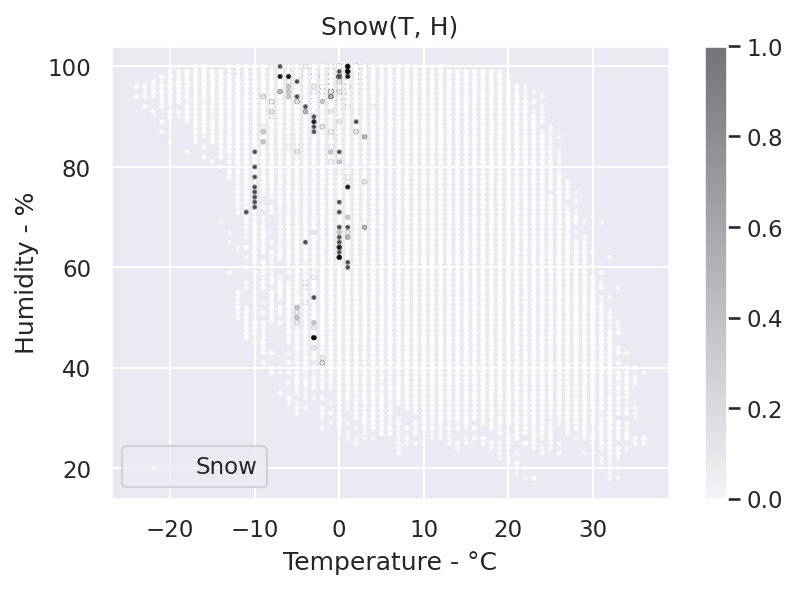

In [67]:
# explore the extracted physical quantities in a 2D scatter chart

def binarize(snow, threshold):
    if snow > threshold:
        return 1
    else:
        return 0

s_bin_list = [binarize(snow, MIN_SNOW_CM) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(figsize=(6, 4), dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, s=2, label="Snow", alpha=0.5)
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

As we can see from the distribution of the black dots, there are cases where the snow formation is reported for temperatures well above 0 Celsius degree. To simplify the analysis, we set the maximum temparature for snow formation as `MELTING_TEMP` and consider the snow formation only when the snowfall is above `MIN_SNOW_CM`. Since we are only forecasting snow, only two classes are needed (__classification problem__).

In [22]:
def gen_label(snow, temperature):
    '''Generate the output labels (Yes and No)'''
    if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
        return "Yes"
    else:
        return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [23]:
# build the dataset

csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

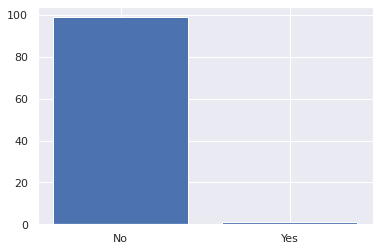

In [24]:
# balance the dataset by undersampling the majority class

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_old, num_snow_samples_old]);

The original dataset is unbalanced because in the selected location (Warsaw, Poland), it typically snows just during the winter season. Since the minority class has many samples (around 2000), we can randomly undersample the majority class so the two categories have the same number of observations. Another approach might include oversampling the minority class (e.g.,  generating them using _SMOTE_ technique).

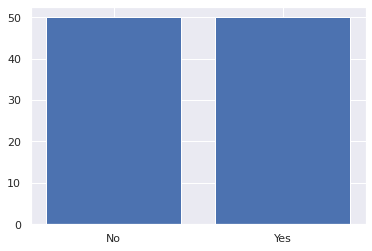

In [25]:
# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
    df0_sub = df0.sample(len(df1.index))
    df_dataset = pd.concat([df0_sub, df1])
else:
    df1_sub = df1.sample(len(df0.index))
    df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_new, num_snow_samples_new]);

In [26]:
# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

,Before - %,After - %
Class,,
% No Snow,98.91,50.0
% Snow,1.09,50.0


## Feature Engineering

In [27]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

COPY ME!
Temperature - [MEAN, STD]   4.28224 8.77749
Humidity - [MEAN, STD]      83.63988 16.4139


> __IMPORTANT:__ Copy the printed mean and standard deviation values printed as they will be required when deploying the __TinyML__ application.

Our input features exist in different numerical ranges. For example, humidity is always between 0 and 100, while the temperature on the Celsius scale can be negative and has a smaller positive numerical range than humidity. The following charts compare the raw and scaled input featue distributions. This is a typical scenario when dealing with various physical quantities and could impact the effectiveness of the model training. As you can observe, Z-score provides roughly the same value range (x-axis) for both temperature and humidity features.

In [28]:
# scale the input features with Z-score independently

def scaling(val, avg, std):
    '''Z-score scaling'''
    return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

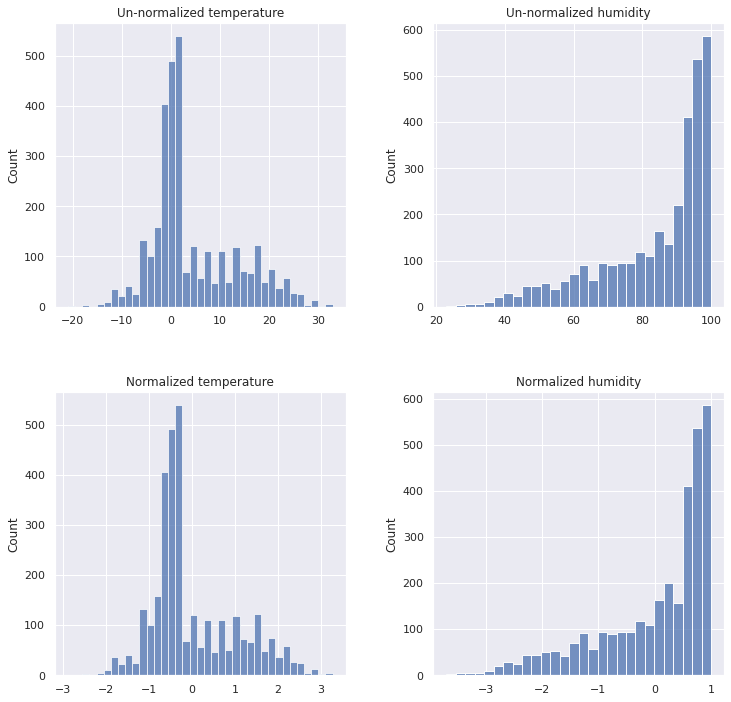

In [29]:
# visualize raw/scaled input features distributions

t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

sns.histplot(t_list, ax=ax[0, 0])
ax[0, 0].set_title("Un-normalized temperature")
sns.histplot(h_list, ax=ax[0, 1])
ax[0, 1].set_title("Un-normalized humidity")

sns.histplot(t_norm_list, ax=ax[1, 0])
ax[1, 0].set_title("Normalized temperature")
sns.histplot(h_norm_list, ax=ax[1, 1])
ax[1, 1].set_title("Normalized humidity")

plt.show()

In [30]:
# export final dataset to CSV file
df_dataset.to_csv(OUTPUT_DATASET_FILE, index=False)

## Deep Learning (DL) Model

In [72]:
# extract the input features and output labels from the df_dataset Pandas DataFrame

X = df_dataset.drop('Snow', axis=1)
y = df_dataset['Snow']

In [73]:
# encode the labels to numerical values

labelencoder = LabelEncoder()
labelencoder.fit(y)
y_encoded = labelencoder.transform(y)

From the original dataset, we assign 85% records to the training set, 7.5% to the validation set, and last 7.5% to the test dataset. With this split, the validation and test datasets contain roughly 250 samples each, enough to see if the model works properly.

In [74]:
# split the dataset into train, validation, and test datasets

# Split 1 (85% vs 15%)
X_train, X_validate_test, y_train, y_validate_test = train_test_split(X, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
X_test, X_validate, y_test, y_validate = train_test_split(X_validate_test, y_validate_test, test_size=0.50, random_state = 3)

One of the most critical aspects to consider when deploying DL networks for __TinyML__ is the model size, generally defined as the memory required for storing the weights (as microcontrollers have very limited physical memory). The created DL model is a __binary classifier__ with an input layer providing the six input features to the network (the temperature and humidity for each of the last three hours) and one output node returning the probability of snowing weather. The structure of the model (consisting all hidden layers) is illustrated in the diagram:

<br>

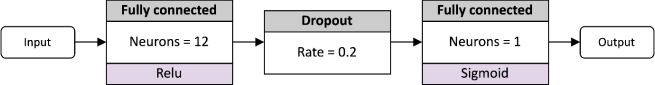

<br>

In [75]:
# create the model with Keras API

model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                84        
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


> __NOTE:__ In __TinyML__ it is important to keep an eye on the number of weights because it strongly affects microcontroller memory utilization.

In [76]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# train the model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_validate, y_validate))

Epoch 1/20
43/43 [==============================] - 1s 5ms/step - loss: 0.6078 - accuracy: 0.5844 - val_loss: 0.5326 - val_accuracy: 0.8091
Epoch 2/20
43/43 [==============================] - 0s 3ms/step - loss: 0.5205 - accuracy: 0.7722 - val_loss: 0.4588 - val_accuracy: 0.8174
Epoch 3/20
43/43 [==============================] - 0s 3ms/step - loss: 0.4639 - accuracy: 0.7986 - val_loss: 0.4081 - val_accuracy: 0.8465
Epoch 4/20
43/43 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8114 - val_loss: 0.3764 - val_accuracy: 0.8631
Epoch 5/20
43/43 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.8247 - val_loss: 0.3544 - val_accuracy: 0.8631
Epoch 6/20
43/43 [==============================] - 0s 3ms/step - loss: 0.3986 - accuracy: 0.8324 - val_loss: 0.3390 - val_accuracy: 0.8631
Epoch 7/20
43/43 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8368 - val_loss: 0.3265 - val_accuracy: 0.8714
Epoch 8/20
43/43 [==

In [79]:
# save the entire TensorFlow model as a SavedModel (ProtoBuffer, TF checkpoint and training parameters)
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: outputs/forecast/assets


INFO:tensorflow:Assets written to: outputs/forecast/assets


Exporting the trained network as `SavedModel` saves the training graph (network architecture, weights, hiperparameters and checkpoints) thus such ___TensorFlow___ model is perfect for sharing or resuming a training session but not suitable for microcontroller deployment due to computational and memory constraints. Later on we will transform ___TensorFlow___ model into [___TensorFlow Lite (TFLite)___](https://www.tensorflow.org/lite/guide) model, and finally convert it to C-byte array.

## Evaluation and Performance

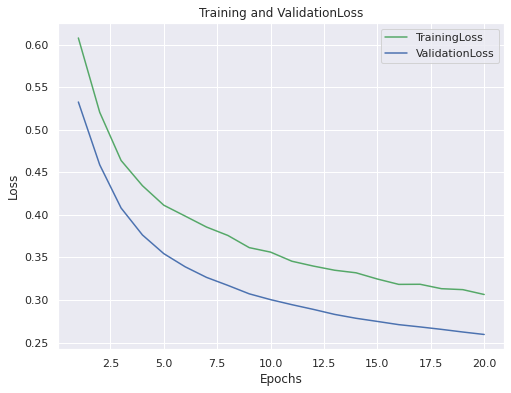

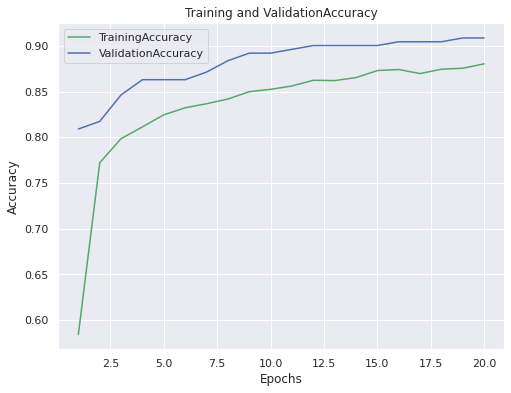

In [78]:
# analyze the accuracy and loss after each training epoch

loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(X, y_train, y_val, type_txt):
    plt.figure(figsize = (8, 6))
    plt.plot(X, y_train, 'g', label='Training'+type_txt)
    plt.plot(X, y_val, 'b', label='Validation'+type_txt)
    plt.title('Training and Validation'+type_txt)
    plt.xlabel('Epochs')
    plt.ylabel(type_txt)
    plt.legend()
    plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

From the plots we see the accuracy and loss of our model in each training epoch thus can see the trend of model performance. The validation accuracy and loss obtain _a plateau_ after c.a. 10 epochs and there is no evidence of overfitting or underfitting (the smaller loss for validation rather than training set can be explained by the fact the validation loss is calculated at the end of each training epoch). Thus, we should consider terminating the training earlier to prevent overfitting for other datasets (using e.g., `EarlyStopping()` method). However, accuracy and loss are not enough to judge the model performance.

8/8 [==============================] - 0s 2ms/step


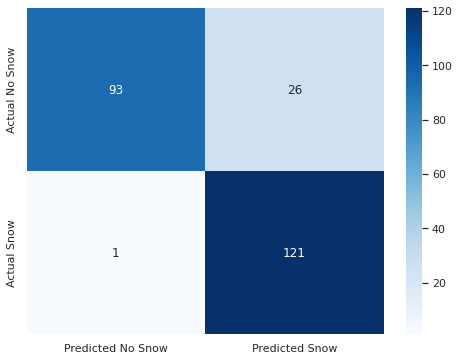

In [89]:
# visualize the confusion matrix

y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues");

From confussion matrix we see the samples are mainly distributed on the diagonal, and there are more false-positives than false-negatives. Therefore, alhtough the network is suitable for detecting snow, we should expect some false detections.

In [81]:
# calculate Recall, Precision, and F-score performance metrics

TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.888
Recall:     0.992
Precision:  0.823
F-score:    0.9


As we can see from the high ___recall___, our model can forecast the snow with high confidence. However, because of lower ___precision___ we should expect some false alarms. Finally, ___F-score___ tells us ___recall___ and ___precision___ are well-balanced. Therefore, we have a good ML model suitable for microcontroller deployment.

## TensorFlow Lite Conversion

[**TFLite**](https://www.tensorflow.org/lite/guide) is a deep learning framework specifically for inference on edge devices (smartphones and embedded platforms) which provides a set of tools for converting the **TF** model into a lightweight representation and running the model efficiently on the target device, as presented in the following diagram:

<br>

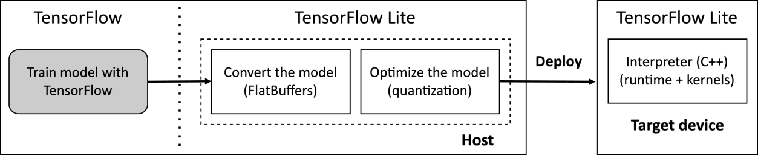

<br>


In [83]:
# import the TensorFlow SavedModel directory into TensorFlow Lite Converter
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

Memorory constraint is not the only challenge when deploying a model on microcontrollers. Although the trained model commonly employs arithmetic operations in floating-point precision, CPUs on microcontrollers normally do not support them. [Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is the process of performing neural network computations in lower bit precision. The widely adopted technique for microcontrollers applies quantization post-training and converst 32-bit floating-point weights to 8-bit integer values. This technique brings four times model size reduction and a significant latency improvement with very little or no accuracy drop.

In [82]:
# TFLite converter uses X_test for calibration

def representative_data_gen():
    '''Select a few hundred of samples randomly from the training dataset to calibrate the quantization'''
    for i_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [84]:
# initialize TensorFlow Lite converter for the 8-bit quantization

converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

The previous step is commonly called _generating a representative dataset_, and is essential to reduce the risk of an accuracy drop in the quantization process. In fact, the converter uses this set of samples to find out the range of the input values and then estimates the quantization parameters.

In [85]:
# convert the model to TensorFlow Lite file format (FlatBuffers) and save it as .tflite

tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

2023-09-26 15:43:10.709401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-09-26 15:43:10.709473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-09-26 15:43:10.709942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: outputs/forecast
2023-09-26 15:43:10.723287: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-09-26 15:43:10.723322: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: outputs/forecast
2023-09-26 15:43:10.729147: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-09-26 15:43:10.785259: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: outputs/forecast
2023-09-26 15:43:10.793024: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 83086 m

2104

In [86]:
# convert the TensorFlow Lite model to C-byte array with xxd

!apt-get update && apt-get -qq install xxd
!xxd -i outputs/forecast_model.tflite > outputs/model.h  # model conversion and storage in 'model.h' C header file
!cat outputs/model.h  # array of hexadecimal numbers interpreted by TFLu framework on microcontroller

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
unsigned char outputs_forecast_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0x60, 0x02, 0x00, 0x00,
  0x70, 0x02, 0x00, 0x00, 0xcc, 0x07, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x56, 0xfd, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,


The previous command outputs a C header file containing ___TFLite___ model as an _unsigned char_ array since microcontrollers do not have OS and native filesystem support (to load the data from `*.tflite` file). Therefore, it allows us to integrate the model directly into the application in a memory-efficient way.

## Deployment on Arduino Board

___Arduino Nano 33 BLE Sens___ has built-in __TPH__ (temperature, pressure and humidity) sensors so we do not need external components for building a simple weather station. The Arduino board integrates ultra-compact and extremaly low-power [HTS221 sensor](https://www.st.com/en/mems-and-sensors/hts221.html) for relative humidity and temperature measurements.

<br>

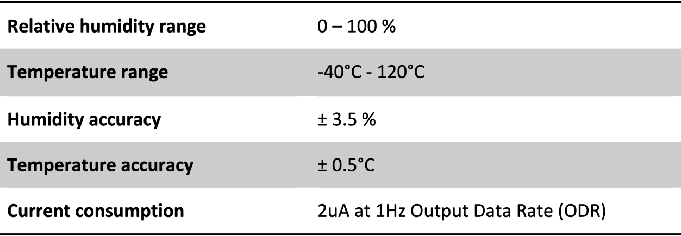

> __IMPORTANT__: Due to [self-heating](https://forum.arduino.cc/t/how-to-make-a-weather-station-and-fix-temperature-sensor-readings-on-the-sense/624985), when the ___Arduino Nano 33 BLE Sens___ board is powered by USB, the HTS221 sensor becomes unreliable and shows an offset in each reading that changes with the external temperature. Thus, powering the board with batteries is recommended.

Please find an additional Jupyter Notebook with [ArduinoSketches](./notebook_ArduinoSketches.ipynb) written in C language for __TFLu__ model deployment on ___Arduino Nano 33 BLE Sens___ board. __TFLu__ framework does not need setting up as it is included as a separate library in the Arduino IDE environment. For those interested, very good, official tutorial showing how to configure the Arduino IDE, install __TFLu__ library and run first programs on ___Arduino Nano 33 BLE Sens___ can be found [here](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning). Inference with __TFLu__ typically consists of the following steps, implemented in the Arduino application via external libraries:
1. __Loading and parsing the TFLite model__: TFLu parses the weights and network architecture stored in the C-byte array generated before
2. __Transforming the input data__: the input data acquired from the sensors is converted to the quantized format expected by the TFLu model
3. __Executing the model__: TFLu executes the model using optimized deep neural network functions (like convolutions, matrix multiplications, etc.)

> __NOTE__: At the end of Arduino sketches code, there is a delay of <u>two seconds</u> but is should be <u>one hour</u> in the actual application! The pause of two seconds is used to avoid waiting too long in our experiments (we have decided to predict weather in an hourly manner). Also, in the `DEBUG_SNOW` mode there are implemented conditions where model predict snowing weather (to check if the logic of Arduino application works). Please remember that ___mean___ and ___std___ of temperature and humidity extracted from TF model <u>must be copied</u> into Arduino code as well.

After compiling and uploading the `classification.ino` sketch on the Arduino board, the serial port monitor in the _Arduino IDE_ will report ___Yes, it snows___ or ___No, it does not snow___, depending on whether snow is forecast at the moment. To check if the application can forecast snow, you can simply force the temperature to -10 Celsisus degree and humidity to 100%. The model should then return ___Yes, it snows___ message on the serial port monitor.

__TO BE COMPLETED:__ photos of the model, example results, screenshots from serial port monitor, etc.

## Conclusion and Perspectives

__TO BE COMPLETED:__ what can be improved, comparison with similar models, different data sources, etc.